In [ ]:
# Upgrade matplotlib con Colab
# !pip install matplotlib --upgrade

## Reducción de dimensiones

Son métodos numéricos y/o visuales
- Representar la variabilidad presente en un conjunto de datos
- Con menos variables explicatorias
  - No es la simple eliminación de las variables explicatorias existentes
  - Es la construcción de un número menor de variables como combinación de las
    demás.


### Analisis de componentes principales

- Transformación lineal de los datos en nuevos sistemas de coordenadas.
  - El objetivo es que haya algunas de esas dimensiones
    - acumulen la mayor parte de información
  - Las dimensiones con menos información se eliminan

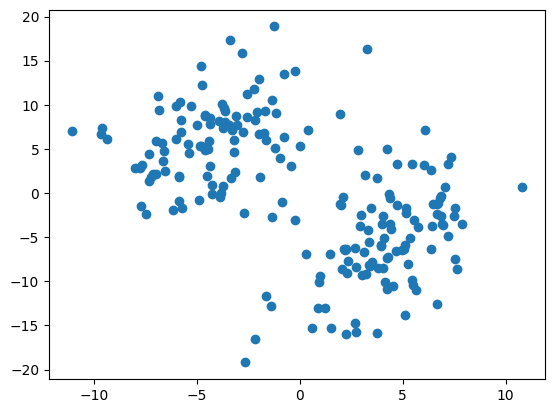

In [25]:
import scipy.stats as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

xa = st.norm.rvs(4, 2.5, size=100)
ya = st.norm.rvs(size=100) * 4.5 + 0.9 * xa - 10
xb = st.norm.rvs(-4, 2.5, size=100)
yb = st.norm.rvs(size=100) * 4.5 + 0.9 * xb + 10

np.concatenate((xa, xb))

data = pd.DataFrame(
    data = {
        "X" : np.concatenate((xa, xb)),
        "Y" : np.concatenate((ya, yb))
    }
)
data.head()
plt.scatter(data.X, data.Y)

¿Hay formación de grupos de datos?

¿Hay grupos en las proyecciones sobre los ejes?

([<matplotlib.axis.YTick at 0x16652f0a6a0>,
 [Text(0, 1, 'X'), Text(0, 2, 'Y')])

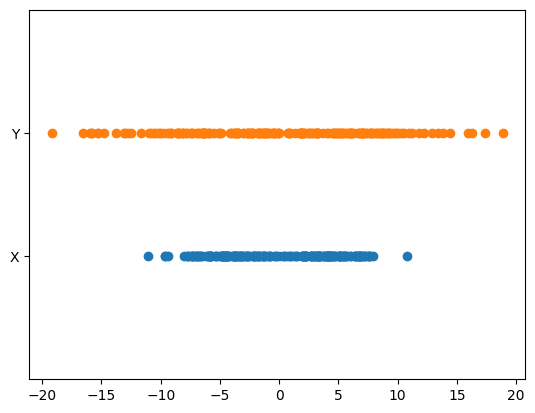

In [26]:
plt.scatter(
    x = data.X,
    y = [1] * len(data.X)
)
plt.scatter(
    x = data.Y,
    y = [2] * len(data.Y)
)

plt.ylim(0,3)
plt.yticks([1, 2], labels = ["X", "Y"])

¿Qué pasa si ratamos los puntos?

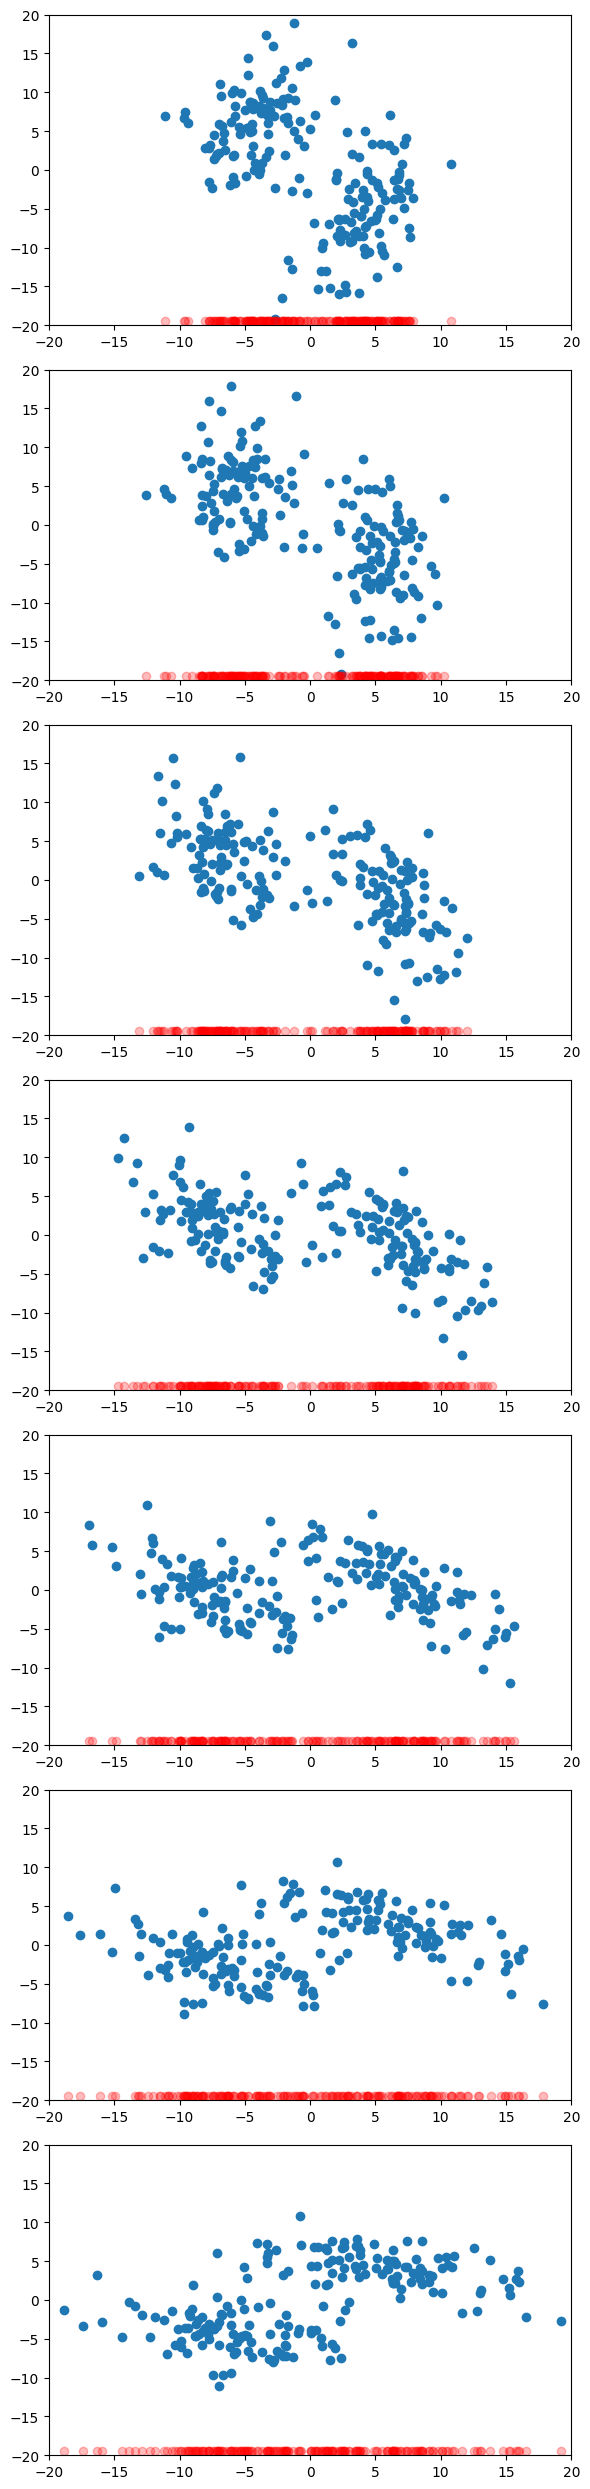

In [32]:
import math

fig, axes = plt.subplots(
    nrows=7,
    figsize = (6, 25)
)

for i, angle in enumerate([0, 15, 30, 45, 60, 75, 90]):
    angle = angle * math.pi / 180
    rmat = np.array(
        [
            [math.cos(angle), -math.sin(angle)],
            [math.sin(angle), math.cos(angle)]
        ]
    )
    rotated = (rmat @ data.T).T
    axes[i].scatter(
        rotated.iloc[:, 0],
        rotated.iloc[:, 1]
    )
    axes[i].set_ylim(-20, 20)
    axes[i].set_xlim(-20, 20)

    axes[i].scatter(
        x = rotated.iloc[:, 0],
        y = [-19.5] * len(rotated),
        color = "#ff000044",
    )
fig.tight_layout()


Text(0.5, 0, 'Component 1: [0.743]')

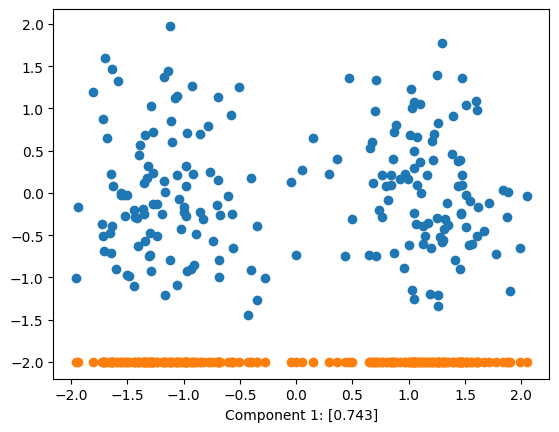

In [4]:
from sklearn import decomposition
from sklearn import preprocessing

pca = decomposition.PCA(n_components=2)

scale = preprocessing.StandardScaler()
scale = scale.fit(data)
data_scaled = scale.transform(data)
fitted = pca.fit(data_scaled)

transformed = fitted.transform(data_scaled)

plt.scatter(
    x = transformed[:, 0],
    y = transformed[:, 1]
)

plt.scatter(
    x = transformed[:, 0],
    y = [-2] * len(transformed)
)
plt.xlabel(f"Component 1: [{fitted.explained_variance_ratio_[0]:.3f}]")


Veamos otro ejemplo con tres dimensiones.

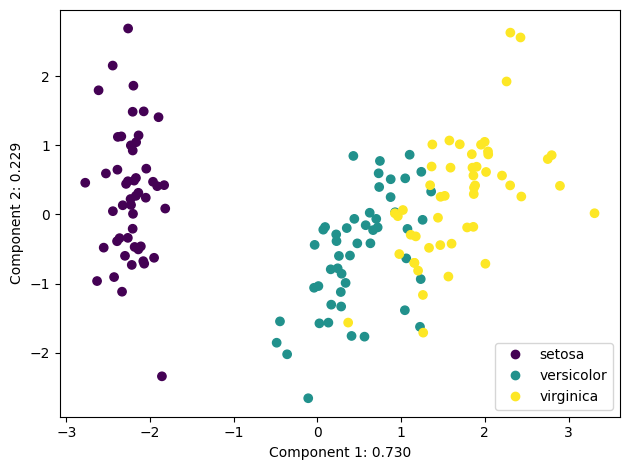

In [5]:
import sklearn.datasets as datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


iris = datasets.load_iris(as_frame=True)
df = iris["frame"]

pca = PCA(n_components=2)

scale = StandardScaler()
scale = scale.fit(df.iloc[:, :4])
iris_scaled = scale.transform(df.iloc[:, :4])

fitted = pca.fit(iris_scaled)
transformed = fitted.transform(iris_scaled)
scatter = plt.scatter(
    x = transformed[:, 0],
    y = transformed[:, 1],
    c = df["target"],
)
legend_elements = scatter.legend_elements()
plt.legend(
    legend_elements[0],
    iris["target_names"],
)
plt.xlabel(f"Component 1: {fitted.explained_variance_ratio_[0]:0.3f}")
plt.ylabel(f"Component 2: {fitted.explained_variance_ratio_[1]:0.3f}")
plt.tight_layout()



### Analisis de correspondencia multiple

- Es una alternativa a PCA, cuando tenemos variables categóricas.

Primero construyamos un set de datos de ejemplo.

In [14]:
import pandas as pd
import scipy.stats as st
data = [
    ("organism", ["homo sapiens", "sus scrofa", "calomys laucha", "xenopus laevis"]),
    ("disorder", ["fully disordered", "highly disordered", "low disorder", "structured"]),
    ("localization" , ["cytoplasm", "nucleus", "p-granule", "mitochondria", "reticulus"]),
    ("llps" , ["driver", "client", "regulator", "not involved"]),
    ("haslcregion", ["yes", "no"]),
    ("hasrnabindingdomain", ["yes", "no"])
]

g1 = [
    [0.25] * 4,
    [0.03, 0.09, 0.40, 0.48],
    [0.25, 0.15, 0.01, 0.20, 0.19],
    [0.01, 0.09, 0.10, 0.80],
    [0.30, 0.70],
    [0.25, 0.75]
]

g2 = [
    [0.25] * 4,
    [0.60, 0.20, 0.20, 0.00],
    [0.05, 0.25, 0.45, 0.15, 0.10],
    [0.50, 0.25, 0.18, 0.02],
    [0.80, 0.20],
    [0.75, 0.25]
]

g3 = [
    [0.25] * 4,
    [0.01, 0.10, 0.88, 0.01],
    [0.85, 0.04, 0.04, 0.04, 0.03],
    [0.25, 0.25, 0.25, 0.25],
    [0.50, 0.50],
    [0.50, 0.50]
]

groups = [g1, g2, g3]
gs = [0.35, 0.35, 0.30]

n = 1000

gr = st.multinomial.rvs(1, gs, n)
gr = np.apply_along_axis(np.argmax, 1, gr)

def create_sample_from_group(group):
    values = [group]
    for (var, labels), frq in zip(data, groups[group]):
        lbl_index = np.apply_along_axis(np.argmax, 1, st.multinomial.rvs(1,frq,1))
        values.append(labels[lbl_index[0]])
    return values

sim_data = map(create_sample_from_group, gr)

df = pd.DataFrame(
    data = sim_data,
    columns = ["group"] + [x[0] for x in data]
)

In [33]:
df

,group,organism,disorder,localization,llps,haslcregion,hasrnabindingdomain
0,0,calomys laucha,structured,cytoplasm,driver,yes,no
1,1,calomys laucha,highly disordered,p-granule,driver,yes,yes
2,0,calomys laucha,structured,reticulus,not involved,no,no
3,0,sus scrofa,fully disordered,cytoplasm,client,no,yes
4,1,homo sapiens,fully disordered,mitochondria,regulator,no,yes
...,...,...,...,...,...,...,...
995,0,sus scrofa,low disorder,reticulus,client,yes,no
996,0,xenopus laevis,low disorder,cytoplasm,not involved,no,no
997,2,calomys laucha,low disorder,cytoplasm,not involved,yes,no
998,2,calomys laucha,low disorder,cytoplasm,regulator,yes,no


Text(0, 0.5, 'Dimension 2 (Inertia: 8.998)%')

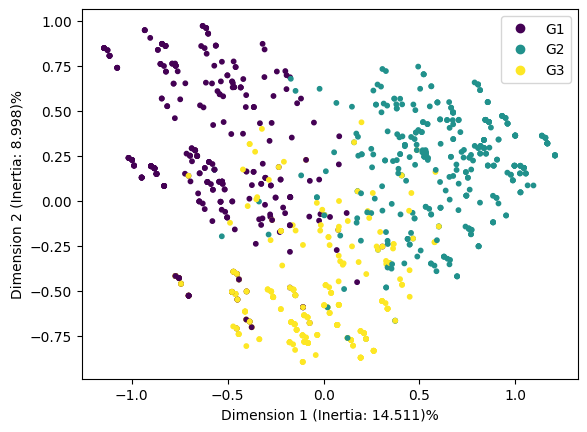

In [34]:
import prince

mca = prince.MCA(n_components=6)
fitted = mca.fit(df.iloc[:, 1:])
transformed = mca.transform(df.iloc[:, 1:])

scatter = plt.scatter(
    transformed.iloc[:, 0],
    transformed.iloc[:, 1],
    c = df["group"],
    s = 10
)
legend_elements = scatter.legend_elements()
plt.legend(legend_elements[0], ["G1", "G2", "G3"])
plt.xlabel(F"Dimension 1 (Inertia: {100*fitted.explained_inertia_[0]:0.3f})%")
plt.ylabel(F"Dimension 2 (Inertia: {100*fitted.explained_inertia_[1]:0.3f})%")

Podemos asignar coordenadas a las categorias, no solo a los datos.

In [35]:
column_coordinates = fitted.column_coordinates(
    df.iloc[:, 1:]
)
column_coordinates

,0,1,2,3,4,5
organism_calomys laucha,-0.104204,0.117822,0.936632,0.340294,-0.287909,0.204102
organism_homo sapiens,-0.001077,-0.003825,0.325202,-0.768225,0.142491,-0.774358
organism_sus scrofa,-0.038653,0.085223,-0.616855,-0.550133,-0.119613,1.166016
organism_xenopus laevis,0.142940,-0.193347,-0.727393,0.822480,0.274550,-0.530574
disorder_fully disordered,1.146691,0.718900,-0.056105,-0.343298,-0.492517,-0.405026
disorder_highly disordered,0.631154,0.244740,0.611215,0.887789,1.170277,1.049570
disorder_low disorder,-0.292319,-0.717718,-0.035111,0.032719,-0.117323,-0.129474
disorder_structured,-1.177158,1.149372,-0.303895,-0.346414,0.129670,0.144305
localization_cytoplasm,-0.370655,-0.995910,-0.072294,0.038852,0.021155,0.150314
localization_mitochondria,-0.065991,1.022631,-0.602011,0.602886,-0.368758,0.883759


In [18]:
column_coordinates.index.map(lambda x: x.startswith("disorder_"))
disorder_col = column_coordinates.iloc[
    column_coordinates.index.map(lambda x: x.startswith("disorder_")),
    [0, 1]
]
disorder_col

,0,1
disorder_fully disordered,1.146691,0.718900
disorder_highly disordered,0.631154,0.244740
disorder_low disorder,-0.292319,-0.717718
disorder_structured,-1.177158,1.149372


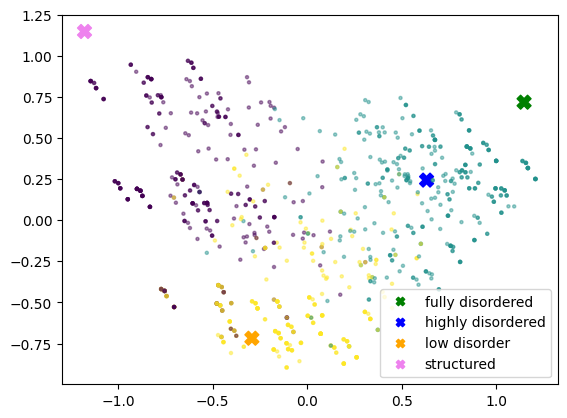

In [36]:
import matplotlib
import numpy as np
colors = ["green", "blue", "orange", "violet"]
cmap, norm = matplotlib.colors.from_levels_and_colors(
    np.arange(len(colors)),
    colors,
    extend = "max"
)

scatter = plt.scatter(
    disorder_col.iloc[:, 0],
    disorder_col.iloc[:, 1],
    c = np.arange(len(disorder_col)),
    marker = "X",
    cmap = cmap,
    norm = norm,
    s = 100
)
legend_elements = scatter.legend_elements()
legend_labels = disorder_col.index.map(lambda x: x.split("_")[1])
plt.legend(
    legend_elements[0],
    legend_labels
)
plt.scatter(
    transformed.iloc[:, 0],
    transformed.iloc[:, 1],
    s = 5,
    c = df["group"],
    alpha = 0.45
)